# Capstone 3: Modeling
<b>PROJECT GOAL</b><br>
The goal of this project is to understand and predict the valuation of publicly-traded companies as measured by market capitalization (the target or response variable).  Financial statement data will be used as predictor variables (features) to assess whether regression models of these fundamental variables can predict future market capitalization.<br>

<b>DATA</b><br>
All data are sourced from Alpha Vantage via their API (https://www.alphavantage.co/documentation/).

<i>response variable (target)</i><br>
market capitalization = [number of shares outstanding] x [share price]<br><br>
<i>predictor variables (features)</i><br>
The features are metrics from financial statements such as revenue, revenue growth year-over-year, etc.  A core set of metrics to be used as features was defined in the exploratory data analysis notebook.

## 1 Import Python Modules, Load Data, Train-Test Split, Scale Data

Import Python modules, load target and feature data from exploratory data analysis notebook.

In [472]:
import pandas as pd
import numpy as np
import datetime as dttm
import itertools as itool

from sklearn.preprocessing import StandardScaler, PowerTransformer   #QuantileTransformer, RobustScaler
from sklearn.metrics import SCORERS, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, layers

import matplotlib.pyplot as plt
import seaborn as sns
#import graphviz

import json

In [4]:
#virtual environment
#!pip freeze > env_spbdcp031.txt

In [5]:
#as of date
statusdate01 = dttm.date(2021,9,30)

In [6]:
#load target, feature data
data_elmt011 = 'yxdata_eda_'

#json
filnm011 = '../data/sec_' + data_elmt011 + statusdate01.strftime('%Y%m%d') + '.json'

with open(filnm011) as f011:
    sec_res_dict011 = json.load(f011)
        
df_sec_yxdata011 = pd.DataFrame.from_dict(sec_res_dict011)

lst_yxdata_dates011 = ['fisc_date_t', 'fisc_date_tp1', 'meas_date_t', 'meas_date_tp1', 
    'rpt_date_t', 'rpt_date_tp1', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5']

for lst_date_itm011 in lst_yxdata_dates011:
    df_sec_yxdata011.loc[:,lst_date_itm011] = pd.to_datetime(df_sec_yxdata011.loc[:,lst_date_itm011])
    
del f011, sec_res_dict011

In [7]:
#define core metrics, data
lst_yx_coreattmet011 = ['ticker','mkt_cap_202109','fisc_seq','fisc_intvl','rpt_ccy','inscope_flg',
    'fisc_date_t', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5', 'meas_date_tp1',
    'mktcap_sec_tp1',
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']

#in scope, core attributes & metrics
is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True
df_sec_yxdata_core011 = df_sec_yxdata011.loc[is_yx_inscope011,lst_yx_coreattmet011].copy()
df_sec_yxdata_core011.reset_index(drop=True,inplace=True)
df_sec_yxdata_core011.info()
df_sec_yxdata_core011.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9723 entries, 0 to 9722
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ticker          9723 non-null   object        
 1   mkt_cap_202109  9723 non-null   float64       
 2   fisc_seq        9723 non-null   float64       
 3   fisc_intvl      9723 non-null   float64       
 4   rpt_ccy         9723 non-null   object        
 5   inscope_flg     9723 non-null   bool          
 6   fisc_date_t     9723 non-null   datetime64[ns]
 7   fisc_date_tm1   9723 non-null   datetime64[ns]
 8   fisc_date_tm4   9723 non-null   datetime64[ns]
 9   fisc_date_tm5   9723 non-null   datetime64[ns]
 10  meas_date_tp1   9723 non-null   datetime64[ns]
 11  mktcap_sec_tp1  9723 non-null   float64       
 12  clsadj_etf_t    9723 non-null   float64       
 13  rev             9723 non-null   float64       
 14  rev_yoy         9723 non-null   float64       
 15  rev_

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,...,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.265762,0.070318,561000000.0,1.854800e+10,3.447000e+09,72000000.0,2.398100e+10,1.067000e+10,0.269710,0.038440
1,AAPL,2.358033e+12,4.0,90.0,USD,True,2020-12-31,2020-09-30,2019-12-31,2019-09-30,...,0.259519,0.015259,0.0,2.477500e+10,3.613000e+09,74000000.0,3.876300e+10,8.247000e+09,0.349843,0.014628
2,AAPL,2.358033e+12,3.0,92.0,USD,True,2020-09-30,2020-06-30,2019-09-30,2019-06-30,...,0.195879,-0.017831,450000000.0,1.718700e+10,3.511000e+09,32000000.0,2.057600e+10,6.660000e+08,0.318031,0.007132
3,AAPL,2.358033e+12,2.0,92.0,USD,True,2020-06-30,2020-03-31,2019-06-30,2019-03-31,...,0.190768,0.001054,0.0,1.589100e+10,3.656000e+09,27000000.0,1.627100e+10,4.635000e+09,0.275836,0.056052
4,AAPL,2.358033e+12,1.0,91.0,USD,True,2020-03-31,2019-12-31,2019-03-31,2018-12-31,...,0.195444,-0.007362,428000000.0,1.857400e+10,3.375000e+09,-68000000.0,1.331100e+10,2.156000e+09,0.231270,0.035586


## 2 Transform and Scale Data

abc

In [8]:
#add indicator features
df_sec_yxdata_core011['gp_mgn_flg'] = df_sec_yxdata_core011.loc[:,'gp_mgn'].apply(lambda x: 1 if x != 1 else 0)
df_sec_yxdata_core011['sh_iss_flg'] = df_sec_yxdata_core011.loc[:,'sh_iss'].apply(lambda x: 1 if x != 0 else 0)
df_sec_yxdata_core011['sh_rprch_flg'] = df_sec_yxdata_core011.loc[:,'sh_rprch'].apply(lambda x: 1 if x != 0 else 0)
df_sec_yxdata_core011['div_flg'] = df_sec_yxdata_core011.loc[:,'div'].apply(lambda x: 1 if x != 0 else 0)

In [9]:
df_sec_yxdata_core011.head()

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,...,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy,gp_mgn_flg,sh_iss_flg,sh_rprch_flg,div_flg
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,3.447000e+09,72000000.0,2.398100e+10,1.067000e+10,0.269710,0.038440,1,1,1,1
1,AAPL,2.358033e+12,4.0,90.0,USD,True,2020-12-31,2020-09-30,2019-12-31,2019-09-30,...,3.613000e+09,74000000.0,3.876300e+10,8.247000e+09,0.349843,0.014628,1,0,1,1
2,AAPL,2.358033e+12,3.0,92.0,USD,True,2020-09-30,2020-06-30,2019-09-30,2019-06-30,...,3.511000e+09,32000000.0,2.057600e+10,6.660000e+08,0.318031,0.007132,1,1,1,1
3,AAPL,2.358033e+12,2.0,92.0,USD,True,2020-06-30,2020-03-31,2019-06-30,2019-03-31,...,3.656000e+09,27000000.0,1.627100e+10,4.635000e+09,0.275836,0.056052,1,0,1,1
4,AAPL,2.358033e+12,1.0,91.0,USD,True,2020-03-31,2019-12-31,2019-03-31,2018-12-31,...,3.375000e+09,-68000000.0,1.331100e+10,2.156000e+09,0.231270,0.035586,1,1,1,1


In [10]:
#core attributes, target & features, features
lst_yx_coreatt011 = ['ticker','mkt_cap_202109','fisc_seq','fisc_intvl','rpt_ccy','inscope_flg',
    'fisc_date_t', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5', 'meas_date_tp1' ]
lst_yx_coretrgtfeat011 = [
    'mktcap_sec_tp1',
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp_mgn_flg', 'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss_flg', 'sh_iss', 'sh_rprch_flg', 'sh_rprch', 'div_flg', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']
lst_yx_corefeat011 = [
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp_mgn_flg', 'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss_flg', 'sh_iss', 'sh_rprch_flg', 'sh_rprch', 'div_flg', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']

#train
is_train_core_seq011 = df_sec_yxdata_core011.loc[:,'fisc_seq'] <= 4.0
df_yx_train_core011 = df_sec_yxdata_core011.loc[is_train_core_seq011,lst_yx_coretrgtfeat011]
#test
df_yx_test_core011 = df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coretrgtfeat011]

In [131]:
#t_pwr = sign(y)*(sign(y)*y)**(1/k)
#1: none, (sign(y)*y)**(1/k) vs (rev)**(1/k), (sign(y)*flg(y))**(1/k) vs (rev)**(1/k)
#resid = sign(y)*resid

lst_yx_transcale012 = [
    ['mktcap_sec_tp1', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'], 
    
    ['clsadj_etf_t', 't_none', 'flg_none', 's11_none', 's22_mnstd'],
    ['rev', 't_pwr', 'flg_none', 's11_none', 's22_mnstd'],  
    ['rev_yoy', 't_none', 'flg_none', 's11_none', 's22_mnstd'], 
    ['rev_yoy_qdq', 't_none', 'flg_none', 's11_none', 's22_mnstd'],  
    
    ['gp', 't_pwr', 'gp_mgn_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],     
    ['gp_mgn_flg', 't_none', 'flg_none', 's11_none', 's21_none'],   
    ['gp_mgn', 't_none', 'gp_mgn_flg', 's11_none', 's22_mnstd'],   
    ['gp_mgn_ydy', 't_none', 'gp_mgn_flg', 's11_none', 's22_mnstd'],   
    
    ['ni', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'],    
    ['ni_ydy', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'],   
    ['ni_mgn', 't_none', 'flg_none', 's11_none', 's22_mnstd'],   
    ['ni_mgn_ydy', 't_none', 'flg_none', 's11_none', 's22_mnstd'],    
    
    ['sh_iss_flg', 't_none', 'flg_none', 's11_none', 's21_none'],    
    ['sh_iss', 't_pwr', 'sh_iss_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],   
    
    ['sh_rprch_flg', 't_none', 'flg_none', 's11_none', 's21_none'],  
    ['sh_rprch', 't_pwr', 'sh_rprch_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],   
    
    ['div_flg', 't_none', 'flg_none', 's11_none', 's21_none'],   
    ['div', 't_pwr', 'div_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],   
    ['div_ydy', 't_pwr', 'div_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],   
    
    ['cf_op', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'],   
    ['cf_op_ydy', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'],  
    ['cf_op_mgn', 't_none', 'flg_none', 's11_none', 's22_mnstd'],    
    ['cf_op_mgn_ydy', 't_none', 'flg_none', 's11_none', 's22_mnstd'] ]   

df_yx_transcale012 = pd.DataFrame(lst_yx_transcale012, columns=['feat','transform','mix_flg','scale01','scale02'])
df_yx_transcale012

,feat,transform,mix_flg,scale01,scale02
0,mktcap_sec_tp1,t_pwr,flg_none,s12_pwrxrev_resid,s22_mnstd
1,clsadj_etf_t,t_none,flg_none,s11_none,s22_mnstd
2,rev,t_pwr,flg_none,s11_none,s22_mnstd
3,rev_yoy,t_none,flg_none,s11_none,s22_mnstd
4,rev_yoy_qdq,t_none,flg_none,s11_none,s22_mnstd
5,gp,t_pwr,gp_mgn_flg,s13_pwrflgxrev_resid,s22_mnstd
6,gp_mgn_flg,t_none,flg_none,s11_none,s21_none
7,gp_mgn,t_none,gp_mgn_flg,s11_none,s22_mnstd
8,gp_mgn_ydy,t_none,gp_mgn_flg,s11_none,s22_mnstd
9,ni,t_pwr,flg_none,s12_pwrxrev_resid,s22_mnstd


In [141]:
#transform after fit function
def transform_fit(df_data,df_featmap,k):

    #transformed data
    df_data_tr1 = df_data.copy()
    df_data_tr2 = df_data.copy()
    df_yx_posneg = df_data.copy()
    #rev transformed
    df_rev_tran = df_data.loc[:,['rev']]**(1/k)
    
    lst_stats = []
    for idx,rw in df_featmap.iterrows():
        #attributes
        feat_n = rw[0]
        tran_n = rw[1]
        mxflg_n = rw[2]
        scal01_n = rw[3]
        scal02_n = rw[4]
        
        #positive-negative flag
        df_yx_posneg.loc[:,feat_n] = df_data.loc[:,feat_n].apply(lambda x: 1 if x >= 0 else -1)
        df_feat_posneg_n = df_yx_posneg.loc[:,feat_n]
        
        #transform
        if tran_n == 't_pwr':
            df_featn = pd.DataFrame()
            df_featn = df_data.loc[:,feat_n]
            df_data_tr1.loc[:,feat_n] = df_feat_posneg_n*(df_feat_posneg_n*df_featn)**(1/k)
            df_data_tr2.loc[:,feat_n] = df_data_tr1.loc[:,feat_n]
     
        #(0) get mix_flag    
        if mxflg_n == 'flg_none':
            is_1mxflg = df_data.loc[:,feat_n].index >= df_data.loc[:,feat_n].index.min()
        else:
            is_0mxflg = df_data.loc[:,mxflg_n] == 0
            is_1mxflg = df_data.loc[:,mxflg_n] == 1
        
        #(1) statistics
        b0_1n = np.NaN
        b1_1n = np.NaN
        mean0_n = np.NaN
        std0_n = np.NaN
        mean1_n = np.NaN
        std1_n = np.NaN
        #(1.1) non-regression case    
        if (scal02_n == 's22_mnstd') & (scal01_n == 's11_none'):
            #case 1
            if mxflg_n == 'flg_none':
                #mean, std
                mean0_n = np.NaN
                std0_n = np.NaN
                mean1_n = df_data_tr1.loc[is_1mxflg,feat_n].mean()
                std1_n = df_data_tr1.loc[is_1mxflg,feat_n].std()
                #scale
                if std1_n > 0:
                    df_data_tr2.loc[is_1mxflg,feat_n] = (df_data_tr1.loc[is_1mxflg,feat_n] - mean1_n)/std1_n
            #case 0,1
            else:
                #mean, std
                mean0_n = df_data_tr1.loc[is_0mxflg,feat_n].mean()
                std0_n = df_data_tr1.loc[is_0mxflg,feat_n].std()
                mean1_n = df_data_tr1.loc[is_1mxflg,feat_n].mean()
                std1_n = df_data_tr1.loc[is_1mxflg,feat_n].std()
                #scale
                if std0_n > 0:
                    df_data_tr2.loc[is_0mxflg,feat_n] = (df_data_tr1.loc[is_0mxflg,feat_n] - mean0_n)/std0_n
                if std1_n > 0:
                    df_data_tr2.loc[is_1mxflg,feat_n] = (df_data_tr1.loc[is_1mxflg,feat_n] - mean1_n)/std1_n
        #(1.2) regression case 
        #no flag, case 1
        if (scal02_n == 's22_mnstd') & (scal01_n == 's12_pwrxrev_resid'):
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_tran.loc[is_1mxflg,['rev']] 
            #get y data
            df_yreg_n = pd.DataFrame()
            df_yreg_n = df_yx_posneg.loc[is_1mxflg,[feat_n]] * df_data_tr1.loc[is_1mxflg,[feat_n]]
            #regression
            reg_mod1_n = LinearRegression()
            reg_mod1_n.fit(df_xreg_n,df_yreg_n)
            #coefficients
            b0_1n = reg_mod1_n.intercept_[0]
            b1_1n = reg_mod1_n.coef_[0][0]
            #residuals
            df_yregresid_n = pd.DataFrame()
            df_yregresid_n = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yreg_n.loc[:,feat_n] - 
                (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )
            #mean, std
            mean0_n = np.NaN
            std0_n = np.NaN
            mean1_n = df_yregresid_n.mean()
            std1_n = df_yregresid_n.std()  
            #scale
            if std1_n > 0:
                df_data_tr2.loc[is_1mxflg,feat_n] = (df_yregresid_n - mean1_n)/std1_n
        #flag, case 0,1
        elif (scal02_n == 's22_mnstd') & (scal01_n == 's13_pwrflgxrev_resid'):
            #case 0
            #mean, std
            mean0_n = df_data_tr1.loc[is_0mxflg,feat_n].mean()
            std0_n = df_data_tr1.loc[is_0mxflg,feat_n].std()
            #case 1
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_tran.loc[is_1mxflg,['rev']] 
            #get y data
            df_yreg_n = pd.DataFrame()
            df_yreg_n = df_yx_posneg.loc[is_1mxflg,[feat_n]]*df_data_tr1.loc[is_1mxflg,[feat_n]]
            #regression
            reg_mod1_n = LinearRegression()
            reg_mod1_n.fit(df_xreg_n,df_yreg_n)
            #coefficients
            b0_1n = reg_mod1_n.intercept_[0]
            b1_1n = reg_mod1_n.coef_[0][0]
            #residuals
            df_yregresid_n = pd.DataFrame()
            df_yregresid_n = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yreg_n.loc[:,feat_n] - 
                (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )
            #mean, std
            mean1_n = df_yregresid_n.mean()
            std1_n = df_yregresid_n.std()            
            #scale
            if std0_n > 0:
                df_data_tr2.loc[is_0mxflg,feat_n] = (df_data_tr1.loc[is_0mxflg,feat_n] - mean0_n)/std0_n
            if std1_n > 0:
                df_data_tr2.loc[is_1mxflg,feat_n] = (df_yregresid_n - mean1_n)/std1_n
 
        #statistics
        lst_stats.append([feat_n,b0_1n,b1_1n,mean0_n,std0_n,mean1_n,std1_n])    
        
    #results to dataframes
    df_stats = pd.DataFrame(lst_stats,columns=['feat','b0_1','b1_1','mean0','std0','mean1','std1'])
        
    return [df_data_tr2,df_data_tr1,df_featmap,k,df_yx_posneg,df_stats]

In [142]:
#transform function
def transform(df_data,df_featmap,k,df_stats):
    
    #transformed data
    df_data_tr1 = df_data.copy()
    df_data_tr2 = df_data.copy()
    df_yx_posneg = df_data.copy()
    #rev transformed
    df_rev_tran = df_data.loc[:,['rev']]**(1/k)
     
    #loop columns in data
    for feat_n in df_data.columns:
        
        #feature map attributes
        is_feat_map_n = df_featmap.loc[:,'feat'] == feat_n
        rw = df_featmap.loc[is_feat_map_n,:].iloc[0] 
        tran_n = rw[1]
        mxflg_n = rw[2]
        scal01_n = rw[3]
        scal02_n = rw[4]
        #positive-negative flag
        df_yx_posneg.loc[:,feat_n] = df_data.loc[:,feat_n].apply(lambda x: 1 if x >= 0 else -1)
        df_feat_posneg_n = df_yx_posneg.loc[:,feat_n]
        #statistics
        is_feat_stats_n = df_stats.loc[:,'feat'] == feat_n
        b0_1n = df_stats.loc[is_feat_stats_n,'b0_1'].iloc[0]
        b1_1n = df_stats.loc[is_feat_stats_n,'b1_1'].iloc[0]
        mean0_n = df_stats.loc[is_feat_stats_n,'mean0'].iloc[0]
        std0_n = df_stats.loc[is_feat_stats_n,'std0'].iloc[0]
        mean1_n = df_stats.loc[is_feat_stats_n,'mean1'].iloc[0]
        std1_n = df_stats.loc[is_feat_stats_n,'std1'].iloc[0]
        
        #transform
        if tran_n == 't_pwr':
            df_featn = pd.DataFrame()
            df_featn = df_data.loc[:,feat_n]
            df_data_tr1.loc[:,feat_n] = df_feat_posneg_n*(df_feat_posneg_n*df_featn)**(1/k)
            df_data_tr2.loc[:,feat_n] = df_data_tr1.loc[:,feat_n]
     
        #(0) get mix_flag    
        if mxflg_n == 'flg_none':
            is_1mxflg = df_data.loc[:,feat_n].index >= df_data.loc[:,feat_n].index.min()
        else:
            is_0mxflg = df_data.loc[:,mxflg_n] == 0
            is_1mxflg = df_data.loc[:,mxflg_n] == 1
    
        #(1.1) non-regression case    
        if (scal02_n == 's22_mnstd') & (scal01_n == 's11_none'):
            #case 1
            if mxflg_n == 'flg_none':
                #scale
                if std1_n > 0:
                    df_data_tr2.loc[is_1mxflg,feat_n] = (df_data_tr1.loc[is_1mxflg,feat_n] - mean1_n)/std1_n
            #case 0,1
            else:
                #scale
                if std0_n > 0:
                    df_data_tr2.loc[is_0mxflg,feat_n] = (df_data_tr1.loc[is_0mxflg,feat_n] - mean0_n)/std0_n
                if std1_n > 0:
                    df_data_tr2.loc[is_1mxflg,feat_n] = (df_data_tr1.loc[is_1mxflg,feat_n] - mean1_n)/std1_n   

        #(1.2) regression case 
        #no flag, case 1
        if (scal02_n == 's22_mnstd') & (scal01_n == 's12_pwrxrev_resid'):
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_tran.loc[is_1mxflg,['rev']] 
            #get y data
            df_yreg_n = pd.DataFrame()
            df_yreg_n = df_yx_posneg.loc[is_1mxflg,[feat_n]] * df_data_tr1.loc[is_1mxflg,[feat_n]]
            #residuals
            df_yregresid_n = pd.DataFrame()
            df_yregresid_n = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yreg_n.loc[:,feat_n] - 
                (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )
            #scale
            if std1_n > 0:
                df_data_tr2.loc[is_1mxflg,feat_n] = (df_yregresid_n - mean1_n)/std1_n
        #flag, case 0,1
        elif (scal02_n == 's22_mnstd') & (scal01_n == 's13_pwrflgxrev_resid'):
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_tran.loc[is_1mxflg,['rev']] 
            #get y data
            df_yreg_n = pd.DataFrame()
            df_yreg_n = df_yx_posneg.loc[is_1mxflg,[feat_n]]*df_data_tr1.loc[is_1mxflg,[feat_n]]
            #residuals
            df_yregresid_n = pd.DataFrame()
            df_yregresid_n = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yreg_n.loc[:,feat_n] - 
                (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )           
            #scale
            if std0_n > 0:
                df_data_tr2.loc[is_0mxflg,feat_n] = (df_data_tr1.loc[is_0mxflg,feat_n] - mean0_n)/std0_n
            if std1_n > 0:
                df_data_tr2.loc[is_1mxflg,feat_n] = (df_yregresid_n - mean1_n)/std1_n

    return [df_data_tr2,df_data_tr1,df_featmap,k,df_yx_posneg,df_stats]

In [184]:
#inverse transform function
def inv_transform(df_data,df_featmap,k,df_yx_posneg,df_stats):
        
    #inverse transformed data
    df_data_tr1 = df_data.copy()
    df_data_tr2 = df_data.copy()
        #df_data = transformed(0,1)
        #df_data_tr1 = transformed(0,1) > powertransformed
        #df_data_tr2 = powertransformed > original untransformed   
    #rev inverse transformed
    is_feat_stats_n = df_stats.loc[:,'feat'] == 'rev'
    mean1_n = df_stats.loc[is_feat_stats_n,'mean1'].iloc[0]
    std1_n = df_stats.loc[is_feat_stats_n,'std1'].iloc[0]
    df_rev_invtran = ( std1_n*df_data.loc[:,['rev']] + mean1_n )
    
    #loop columns in data
    for feat_n in df_data.columns:
        
        #feature map attributes
        is_feat_map_n = df_featmap.loc[:,'feat'] == feat_n
        rw = df_featmap.loc[is_feat_map_n,:].iloc[0] 
        tran_n = rw[1]
        mxflg_n = rw[2]
        scal01_n = rw[3]
        scal02_n = rw[4]
        #positive-negative flag
        df_feat_posneg_n = df_yx_posneg.loc[:,feat_n]
        #statistics
        is_feat_stats_n = df_stats.loc[:,'feat'] == feat_n
        b0_1n = df_stats.loc[is_feat_stats_n,'b0_1'].iloc[0]
        b1_1n = df_stats.loc[is_feat_stats_n,'b1_1'].iloc[0]
        mean0_n = df_stats.loc[is_feat_stats_n,'mean0'].iloc[0]
        std0_n = df_stats.loc[is_feat_stats_n,'std0'].iloc[0]
        mean1_n = df_stats.loc[is_feat_stats_n,'mean1'].iloc[0]
        std1_n = df_stats.loc[is_feat_stats_n,'std1'].iloc[0]
        
        #(0) get mix_flag    
        if mxflg_n == 'flg_none':
            is_1mxflg = df_data.loc[:,feat_n].index >= df_data.loc[:,feat_n].index.min()
        else:
            is_0mxflg = df_data.loc[:,mxflg_n] == 0
            is_1mxflg = df_data.loc[:,mxflg_n] == 1       
        
        #(1.1) non-regression case    
        if (scal02_n == 's22_mnstd') & (scal01_n == 's11_none'):
            #case 1
            if mxflg_n == 'flg_none':
                #inv scale
                if std1_n > 0:
                    df_data_tr1.loc[is_1mxflg,feat_n] = (std1_n*df_data.loc[is_1mxflg,feat_n] + mean1_n)
            #case 0,1
            else:
                #inv scale
                if std0_n > 0:
                    df_data_tr1.loc[is_0mxflg,feat_n] = (std0_n*df_data.loc[is_0mxflg,feat_n] + mean0_n)
                if std1_n > 0:
                    df_data_tr1.loc[is_1mxflg,feat_n] = (std1_n*df_data.loc[is_1mxflg,feat_n] + mean1_n) 

        #df_data = powertransformed > transformed(0,1)
        #df_data_tr1 = transformed(0,1) > powertransformed
        #df_data_tr2 = powertransformed > origincal untransformed          

        #(1.2) regression case 
        #no flag, case 1
        if (scal02_n == 's22_mnstd') & (scal01_n == 's12_pwrxrev_resid'):
            #unscale
            df_yresidreg_n = pd.DataFrame()
            if std1_n > 0:
                df_yresidreg_n = df_yx_posneg.loc[is_1mxflg,feat_n]*(std1_n*df_data.loc[is_1mxflg,feat_n] + mean1_n) 
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_invtran.loc[is_1mxflg,['rev']]
            #inv regression  
            df_data_tr1.loc[is_1mxflg,feat_n] = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yresidreg_n + (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )

        #flag, case 0,1
        elif (scal02_n == 's22_mnstd') & (scal01_n == 's13_pwrflgxrev_resid'):
            #inv scale
            df_yresidreg_n = pd.DataFrame()
            if std1_n > 0:
                df_yresidreg_n = df_yx_posneg.loc[is_1mxflg,feat_n]*(std1_n*df_data.loc[is_1mxflg,feat_n] + mean1_n) 
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_invtran.loc[is_1mxflg,['rev']]
            #inv regression  
            df_data_tr1.loc[is_1mxflg,feat_n] = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yresidreg_n + (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )
            #case 0 
            if std0_n > 0:
                df_data_tr1.loc[is_0mxflg,feat_n] = (std0_n*df_data.loc[is_0mxflg,feat_n] + mean0_n)         
               
        #inverse transform
        df_featn = pd.DataFrame()
        df_featn = df_data_tr1.loc[:,feat_n]
        if tran_n == 't_pwr':
            df_data_tr2.loc[:,feat_n] = df_feat_posneg_n*(df_feat_posneg_n*df_featn)**(k)
        else:
            df_data_tr2.loc[:,feat_n] = df_data_tr1.loc[:,feat_n]
     
    return [df_data_tr2,df_data_tr1]

In [186]:
#train: fit, transform
lst_train_tran_res012 = transform_fit(df_yx_train_core011,df_yx_transcale012,2)

df_yx_train_tran2011 = lst_train_tran_res012[0]
df_yx_train_tran1011 = lst_train_tran_res012[1]
df_yx_train_featmap011 = lst_train_tran_res012[2]
k_train011 = lst_train_tran_res012[3]
df_yx_train_posneg011 = lst_train_tran_res012[4]
df_yx_train_stats011 = lst_train_tran_res012[5]


#test, transform
lst_test_tran_res012 = transform(df_yx_test_core011,df_yx_train_featmap011,k011,df_yx_train_stats011)

df_yx_test_tran2011 = lst_test_tran_res012[0]
df_yx_test_tran1011 = lst_test_tran_res012[1]
df_yx_test_featmap011 = lst_test_tran_res012[2]
k_test011 = lst_test_tran_res012[3]
df_yx_test_posneg011 = lst_test_tran_res012[4]
df_yx_test_stats011 = lst_test_tran_res012[5]

In [138]:
#df_yx_test_core011.head()
#df_yx_test_tran1011.head()
#df_yx_test_tran2011.head()
#df_yx_test_tran2011.describe()

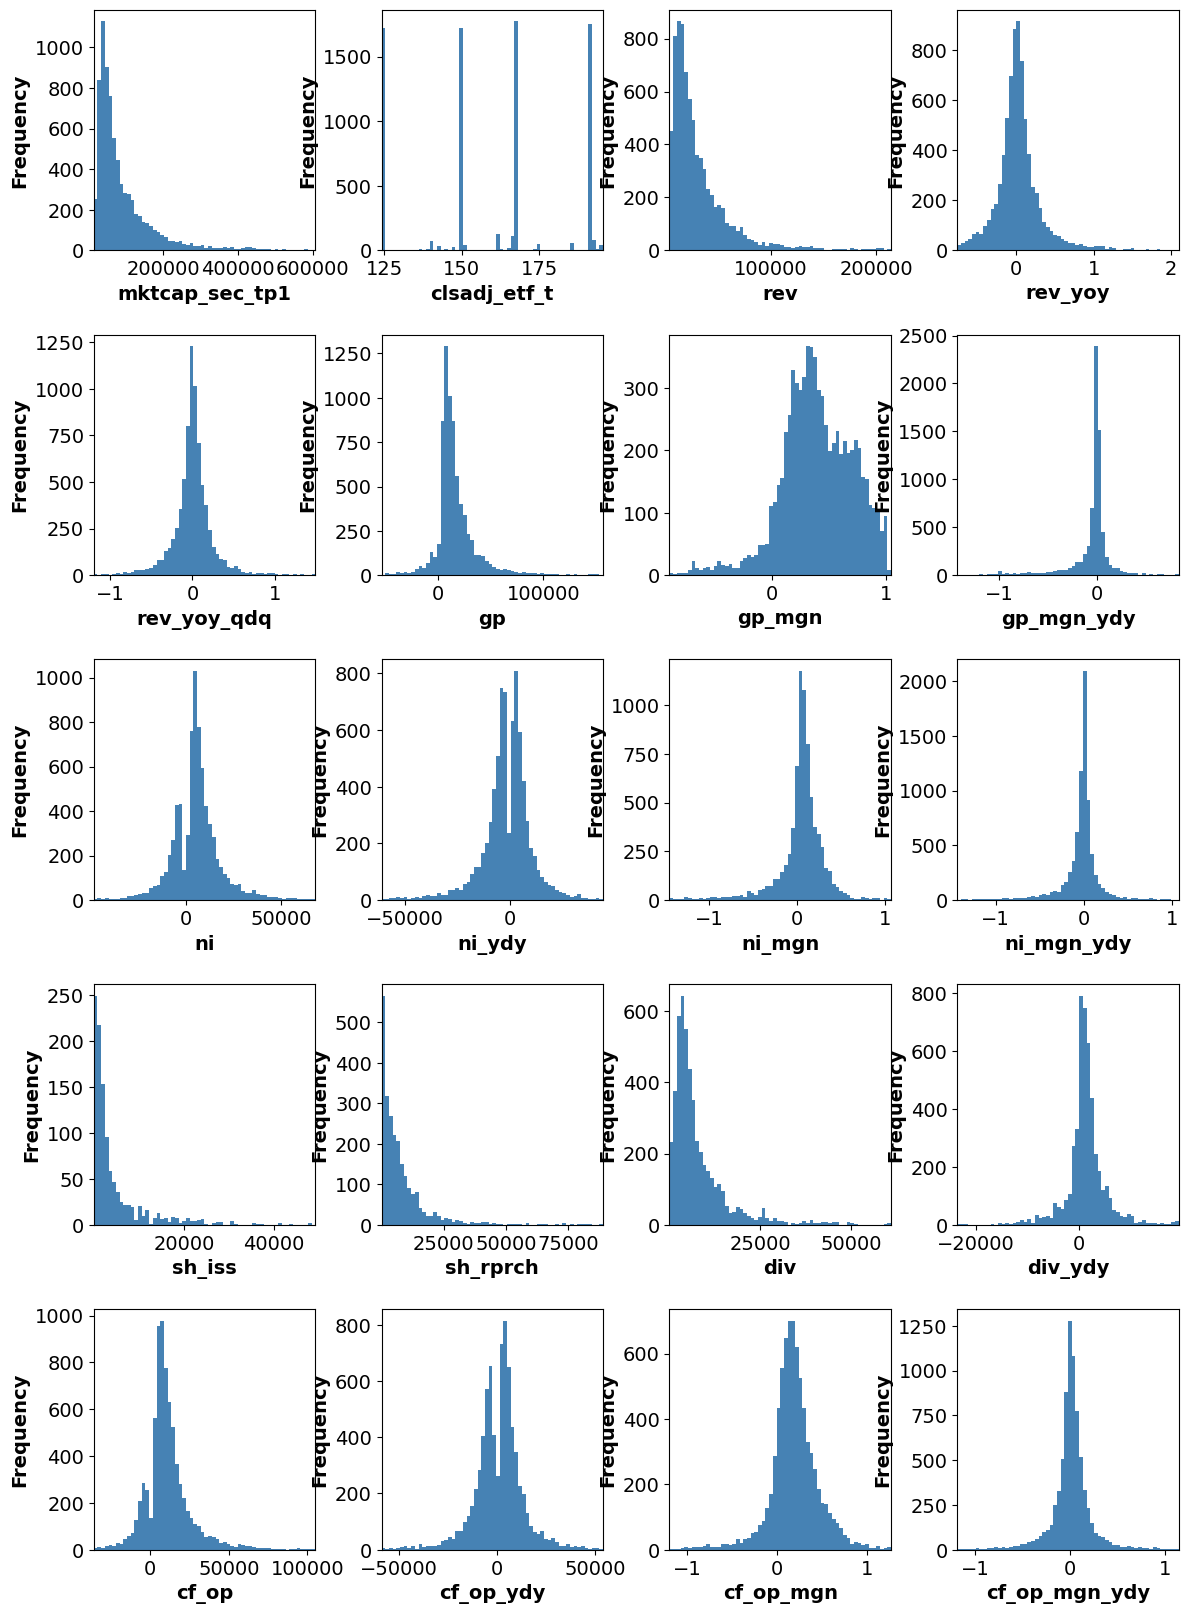

In [192]:
#histograms
fig012, axes012 = plt.subplots(nrows=5,ncols=4,figsize=(14,20))
fig012.subplots_adjust(wspace=0.3, hspace=0.35)
axes_flt012 = axes012.flatten()

is_scaled012 = df_yx_transcale012.loc[:,'scale02'] != 's21_none'

ct012 = -1
for idx012,rw012 in df_yx_transcale012.loc[is_scaled012,:].iterrows():
    
    ct012 = ct012 + 1
    feat012 = rw012['feat']
    mixflg012 = rw012['mix_flg']
    
    axes012_n = axes_flt012[ct012]
    
    #y,x data
    if mixflg012 != 'flg_none':
        is_flgset012 = df_yx_train_tran1011.loc[:,mixflg012] == 1
    else:
        is_flgset012 = df_yx_train_tran1011.index >= df_yx_train_tran1011.index.min()
    df_yxplot012 = df_yx_train_tran1011.loc[is_flgset012,[feat012]]
  
    #bins
    lwbd012 = df_yxplot012.loc[:,feat012].quantile(0.005)
    upbd012 = df_yxplot012.loc[:,feat012].quantile(0.995)
    bwdth012 = (upbd012 - lwbd012)/60
    bin_p012 = np.arange(lwbd012, upbd012 + bwdth012, bwdth012)
    axes012_n.set_xlim(lwbd012,upbd012)
    
    df_yxplot012.loc[:,feat012].plot(ax=axes012_n,kind='hist',bins=bin_p012,color='steelblue')
    axes012_n.set_xlabel(feat012, fontsize=14.0, fontweight='bold')
    axes012_n.tick_params(axis='x', labelsize=14)
    axes012_n.set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
    axes012_n.tick_params(axis='y', labelsize=14) 

plt.show()

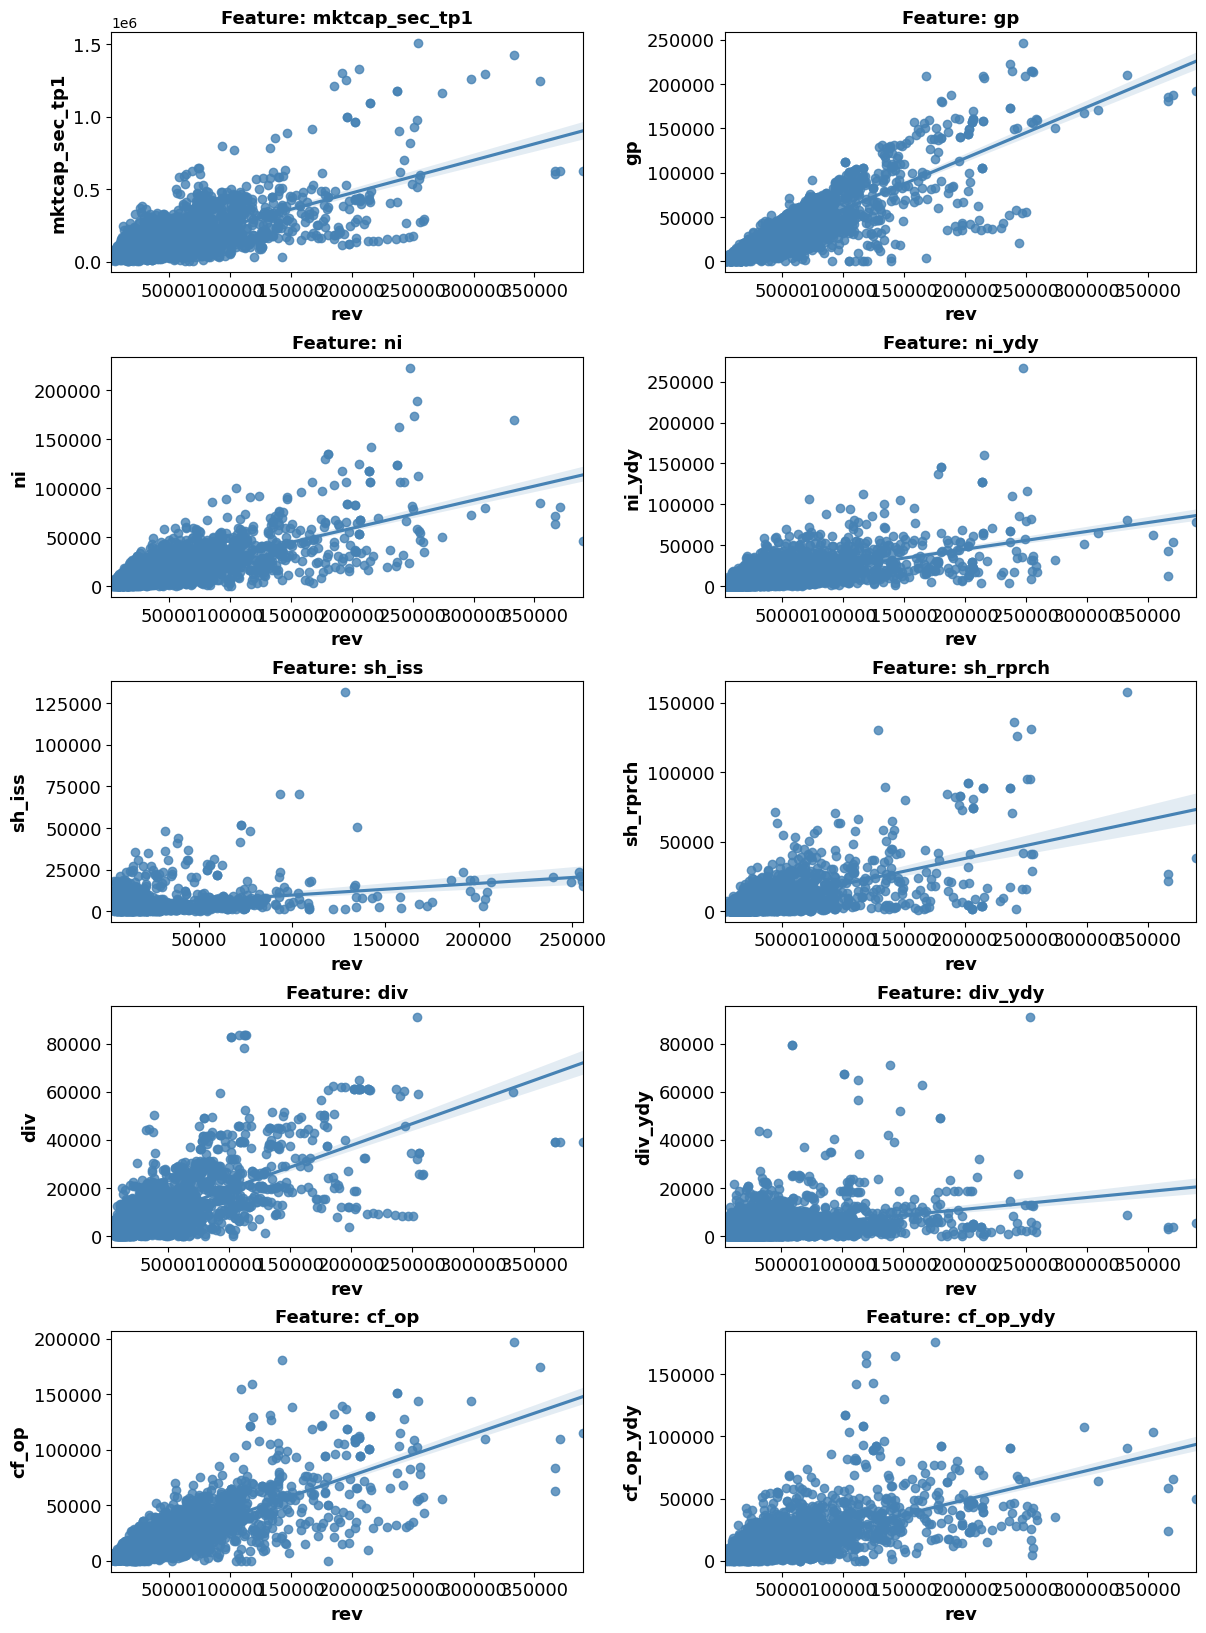

In [193]:
#scatterplots
fig011, axes011 = plt.subplots(nrows=5,ncols=2,figsize=(14,20))
fig011.subplots_adjust(wspace=0.3, hspace=0.35)
axes_flt011 = axes011.flatten()

is_revresid011 = df_yx_transcale012.loc[:,'scale01'] != 's11_none'

ct011 = -1
for idx011,rw011 in df_yx_transcale012.loc[is_revresid011,:].iterrows():
    
    ct011 = ct011 + 1
    feat011 = rw011['feat']
    mixflg011 = rw011['mix_flg']
    sc01_011 = rw011['scale01']
    
    #y,x data
    if mixflg011 != 'flg_none':
        is_flgset011 = df_yx_test_tran1011.loc[:,mixflg011] == 1
    else:
        is_flgset011 = df_yx_test_tran1011.index >= df_yx_train_tran1011.index.min()
    #df_xplot011 = df_yx_test_tran1011.loc[is_flgset011,'rev']
    #df_yplot011 = df_yx_test_tran1011.loc[is_flgset011,feat011]
    #df_yplot011 = df_yx_test_tran1011.loc[is_flgset011,feat011].abs() 
    
    if mixflg011 != 'flg_none':
        is_flgset011 = df_yx_train_tran1011.loc[:,mixflg011] == 1
    else:
        is_flgset011 = df_yx_train_tran1011.index >= df_yx_train_tran1011.index.min()
    df_xplot011 = df_yx_train_tran1011.loc[is_flgset011,'rev']
    #df_yplot011 = df_yx_train_tran1011.loc[is_flgset011,feat011]
    df_yplot011 = df_yx_train_tran1011.loc[is_flgset011,feat011].abs()


    #scatterplot
    axes011_n = axes_flt011[ct011]
    #sns.regplot(ax=axes011_n,x=df_yx_train_core011.loc[:,'rev'],y=df_yx_train_core011.loc[:,feat011]
        #,color='steelblue')
    sns.regplot(ax=axes011_n,x=df_xplot011,y=df_yplot011,color='steelblue')
    axes011_n.set_title('Feature: ' + feat011, fontsize=13.0, fontweight='bold')
    axes011_n.set_xlabel('rev', fontsize=13.0, fontweight='bold')
    axes011_n.tick_params(axis='x', labelsize=13)
    axes011_n.set_ylabel(feat011, fontsize=13.0, fontweight='bold')
    axes011_n.tick_params(axis='y', labelsize=13) 


plt.show()

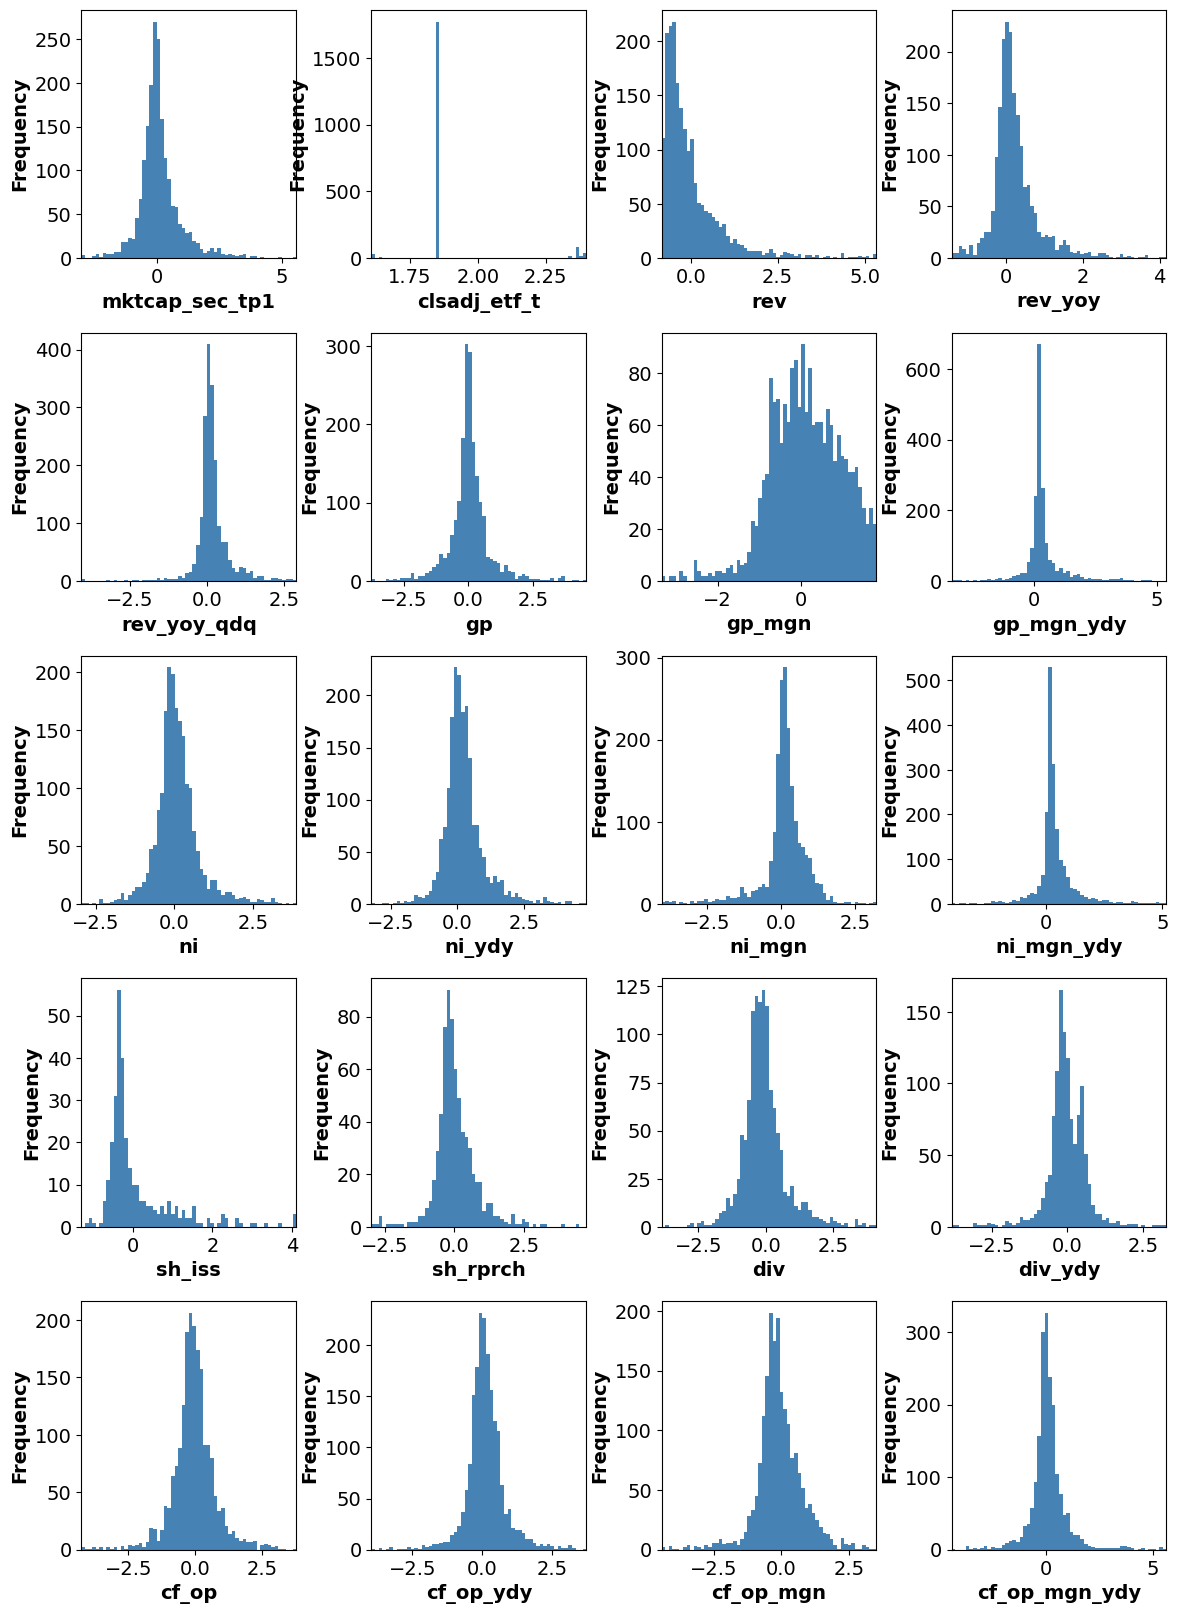

In [205]:
#histograms
fig012, axes012 = plt.subplots(nrows=5,ncols=4,figsize=(14,20))
fig012.subplots_adjust(wspace=0.35, hspace=0.3)
axes_flt012 = axes012.flatten()

is_scaled012 = df_yx_transcale012.loc[:,'scale02'] != 's21_none'

ct012 = -1
for idx012,rw012 in df_yx_transcale012.loc[is_scaled012,:].iterrows():
    
    ct012 = ct012 + 1
    feat012 = rw012['feat']
    mixflg012 = rw012['mix_flg']
    
    axes012_n = axes_flt012[ct012]
    
    #y,x data train
    if mixflg012 != 'flg_none':
        is_flgset012 = df_yx_train_tran2011.loc[:,mixflg012] == 1
    else:
        is_flgset012 = df_yx_train_tran2011.index >= df_yx_train_tran2011.index.min()
    df_yxplot012 = df_yx_train_tran2011.loc[is_flgset012,[feat012]]
    #y,x data test
    if mixflg012 != 'flg_none':
        is_flgset012 = df_yx_test_tran2011.loc[:,mixflg012] == 1
    else:
        is_flgset012 = df_yx_test_tran2011.index >= df_yx_train_tran2011.index.min()
    df_yxplot012 = df_yx_test_tran2011.loc[is_flgset012,[feat012]]  

    #bins
    lwbd012 = df_yxplot012.loc[:,feat012].quantile(0.005)
    upbd012 = df_yxplot012.loc[:,feat012].quantile(0.995)
    bwdth012 = (upbd012 - lwbd012)/60
    bin_p012 = np.arange(lwbd012, upbd012 + bwdth012, bwdth012)
    axes012_n.set_xlim(lwbd012,upbd012)
    
    df_yxplot012.loc[:,feat012].plot(ax=axes012_n,kind='hist',bins=bin_p012,color='steelblue')
    axes012_n.set_xlabel(feat012, fontsize=14.0, fontweight='bold')
    axes012_n.tick_params(axis='x', labelsize=14)
    axes012_n.set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
    axes012_n.tick_params(axis='y', labelsize=14) 

plt.show()

In [195]:
#train, test data
df_x_train011 = df_yx_train_tran2011.loc[:,lst_yx_corefeat011]
df_y_train011 = df_yx_train_tran2011.loc[:,['mktcap_sec_tp1']]
df_x_test011 = df_yx_test_tran2011.loc[:,lst_yx_corefeat011]
df_y_test011 = df_yx_test_tran2011.loc[:,['mktcap_sec_tp1']]

In [196]:
#df_x_train011.head()
#df_y_train011.head()
#df_x_test011.head()
#df_y_test011.head()

df_x_train011.info()
df_y_train011.info()
df_x_test011.info()
df_y_test011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7748 entries, 1 to 9722
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clsadj_etf_t   7748 non-null   float64
 1   rev            7748 non-null   float64
 2   rev_yoy        7748 non-null   float64
 3   rev_yoy_qdq    7748 non-null   float64
 4   gp_mgn_flg     7748 non-null   int64  
 5   gp             7748 non-null   float64
 6   gp_mgn         7748 non-null   float64
 7   gp_mgn_ydy     7748 non-null   float64
 8   ni             7748 non-null   float64
 9   ni_ydy         7748 non-null   float64
 10  ni_mgn         7748 non-null   float64
 11  ni_mgn_ydy     7748 non-null   float64
 12  sh_iss_flg     7748 non-null   int64  
 13  sh_iss         7748 non-null   float64
 14  sh_rprch_flg   7748 non-null   int64  
 15  sh_rprch       7748 non-null   float64
 16  div_flg        7748 non-null   int64  
 17  div            7748 non-null   float64
 18  div_ydy 

## 3 Baseline Models

<b>3.1 LINEAR REGRESSION</b>

In [197]:
#gridsearch cross validation: best k linear regressors
nfeat021 = len(df_x_train011.columns)

#seed
np.random.seed(dttm.datetime.now().microsecond)

#grid search, cross validation 
lr_pipe021 = Pipeline( [ ('selector',SelectKBest(f_regression)), ('model',Lasso()) ] )
lr_gscv021 = GridSearchCV( estimator = lr_pipe021, param_grid = {'selector__k':list(range(1,(10+1))), 
    'model__alpha':[10]},
    scoring='neg_mean_absolute_error', cv=4, verbose=False, n_jobs=4 )

lr_pipe021 = Pipeline( [ ('selector',SelectKBest(f_regression)), ('model',LinearRegression()) ] )
lr_gscv021 = GridSearchCV( estimator = lr_pipe021, param_grid = {'selector__k':list(range(1,(10+1)))},
    scoring='neg_mean_absolute_error', cv=4, verbose=False, n_jobs=4 )
lr_gscv021.fit(df_x_train011,df_y_train011.values.ravel())

df_lr_gscv_res021 = pd.DataFrame(lr_gscv021.cv_results_)

In [198]:
df_lr_gscv_res021.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
7,0.056606,0.001302,0.018039,0.000468,8,{'selector__k': 8},-1.562954,-0.377546,-0.287097,-0.334644,-0.640560,0.533504,1
6,0.054865,0.000819,0.017550,0.000266,7,{'selector__k': 7},-1.563291,-0.379888,-0.289977,-0.332104,-0.641315,0.533253,2
8,0.051198,0.005731,0.015064,0.002670,9,{'selector__k': 9},-1.560323,-0.378019,-0.287407,-0.340255,-0.641501,0.531457,3
5,0.050856,0.006712,0.018868,0.000743,6,{'selector__k': 6},-1.578710,-0.380935,-0.292163,-0.330829,-0.645659,0.539616,4
4,0.051313,0.001476,0.016179,0.002426,5,{'selector__k': 5},-1.586009,-0.386607,-0.286654,-0.332289,-0.647890,0.542778,5
9,0.059876,0.001825,0.017594,0.000503,10,{'selector__k': 10},-1.558281,-0.379044,-0.285989,-0.373961,-0.649319,0.526092,6
3,0.052843,0.000661,0.017961,0.000528,4,{'selector__k': 4},-1.607622,-0.396851,-0.291419,-0.346612,-0.660626,0.548018,7
2,0.052272,0.000602,0.017097,0.000473,3,{'selector__k': 3},-1.610210,-0.395614,-0.292285,-0.363469,-0.665394,0.546770,8
1,0.043810,0.006000,0.016099,0.000187,2,{'selector__k': 2},-1.683913,-0.407341,-0.296546,-0.364928,-0.688182,0.576243,9
0,0.055390,0.000867,0.016498,0.000800,1,{'selector__k': 1},-1.879927,-0.403748,-0.293017,-0.377065,-0.738439,0.660304,10


In [199]:
#linear regression model: fit model with k best regressors
kbest021 = 8

#select k best regressors
lr_sel_kbest021 = SelectKBest(f_regression,k=kbest021).fit(df_x_train011,df_y_train011.values.ravel())
lr_feat_kbest021 = list(lr_sel_kbest021.get_feature_names_out())

x_kbest021 = lr_sel_kbest021.transform(df_x_train011)
df_x_kbest_train021 = df_x_train011.loc[:,lr_feat_kbest021]

#fit linear regression
lr_model_kbest021 = LinearRegression()
lr_model_kbest021.fit(df_x_kbest_train021,df_y_train011.values.ravel())

LinearRegression()

In [200]:
print(lr_model_kbest021.feature_names_in_)
print(lr_model_kbest021.coef_)

['gp' 'gp_mgn' 'ni' 'ni_mgn' 'sh_rprch' 'div' 'cf_op' 'cf_op_mgn']
[ 0.10183303  0.09756931  0.17023976 -0.0463247   0.42449517  0.38671133
  0.14474486 -0.01331413]


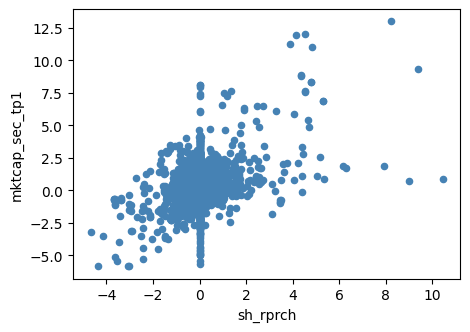

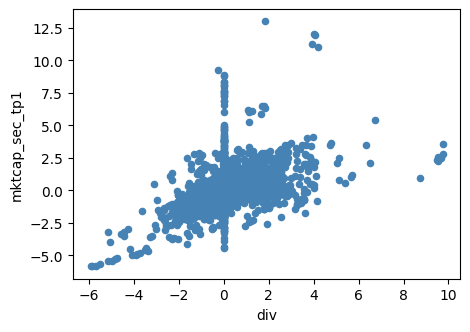

In [670]:
df_yx_train_tran2011.plot(x='sh_rprch',y='mktcap_sec_tp1',kind='scatter',color='steelblue',figsize=(5,3.5))
plt.show()
df_yx_train_tran2011.plot(x='div',y='mktcap_sec_tp1',kind='scatter',color='steelblue',figsize=(5,3.5))
plt.show()
#df_yx_train_tran2011.plot(x='ni',y='mktcap_sec_tp1',kind='scatter',color='steelblue',figsize=(5,3.5))
#plt.show()
#df_yx_train_tran2011.plot(x='cf_op',y='mktcap_sec_tp1',kind='scatter',color='steelblue',figsize=(5,3.5))
#plt.show()

In [219]:
#predictions

#kbest for test set
df_x_kbest_test021 = df_x_test011.loc[:,lr_feat_kbest021]

#transformed
df_lr_model_pred021 = pd.concat([df_y_test011,pd.Series(lr_model_kbest021.predict(df_x_kbest_test021),
    index=df_x_kbest_test021.index)],axis=1)
df_lr_model_pred021.columns = ['y_obs','y_pred']

#unscaled, inverse transform
df_lr_model_pred021 = pd.concat([df_lr_model_pred021,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_lr_model_pred021.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_lr_model_pred_temp021 = pd.concat([df_x_test011.loc[:,['rev']],df_lr_model_pred021.loc[:,['y_pred']].copy()],axis=1)
df_lr_model_pred_temp021.columns = ['rev','mktcap_sec_tp1']
lst_lr_model_pred_invtr021 = inv_transform(df_lr_model_pred_temp021,df_yx_test_featmap011,k_test011,
    df_yx_test_posneg011,df_yx_test_stats011)
df_lr_model_pred_invtran021 = lst_lr_model_pred_invtr021[0]
df_lr_model_pred_invtran021.columns = ['rev','mc_pred']

df_lr_model_pred021 = pd.concat([df_lr_model_pred021,df_lr_model_pred_invtran021.loc[:,['mc_pred']]],axis=1)

#fit metrics
df_lr_model_pred021.loc[:,'mc_resid'] = df_lr_model_pred021.loc[:,'mc_obs'] - df_lr_model_pred021.loc[:,'mc_pred']
df_lr_model_pred021.loc[:,'mc_ae'] = df_lr_model_pred021.loc[:,'mc_resid'].abs()
df_lr_model_pred021.loc[:,'mc_ape'] = df_lr_model_pred021.loc[:,'mc_ae']/df_lr_model_pred021.loc[:,'mc_obs'].abs()
df_lr_model_pred021 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_lr_model_pred021],axis=1)

df_lr_model_pred021.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,11.436157,5.762578,2.245600e+12,1.209637e+12,1.035963e+12,1.035963e+12,0.461330
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,13.407820,6.453107,2.020644e+12,8.700553e+11,1.150589e+12,1.150589e+12,0.569417
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.383738,5.102617,1.644663e+12,8.305149e+11,8.141486e+11,8.141486e+11,0.495024
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.699974,5.102617,1.702156e+12,8.305149e+11,8.716412e+11,8.716412e+11,0.512081
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7.877630,-1.157436,1.735721e+12,4.658736e+11,1.269847e+12,1.269847e+12,0.731596
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.810701,3.655026,1.012507e+12,4.146473e+11,5.978598e+11,5.978598e+11,0.590475
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.001895,-0.378210,6.632374e+11,5.085097e+10,6.123864e+11,6.123864e+11,0.923329
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,5.790132,3.193658,1.004905e+12,6.723805e+11,3.325240e+11,3.325240e+11,0.330901
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,2.221054,0.484721,1.210672e+11,5.104452e+10,7.002264e+10,7.002264e+10,0.578378
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6.888777,3.040001,4.558462e+11,1.637822e+11,2.920640e+11,2.920640e+11,0.640707


In [232]:
#r-squared, mean-ape, median-ape
lr_r2 = r2_score(df_lr_model_pred021.loc[:,'mc_obs'], df_lr_model_pred021.loc[:,'mc_pred'])
lr_meanape = df_lr_model_pred021.loc[:,'mc_ape'].mean()
lr_medape = df_lr_model_pred021.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = pd.DataFrame([['LR',lr_r2,lr_meanape,lr_medape]],
        columns=['model','r-squared','mean-ape','median-ape'],index=[0])
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.673865,1.758949,0.468692


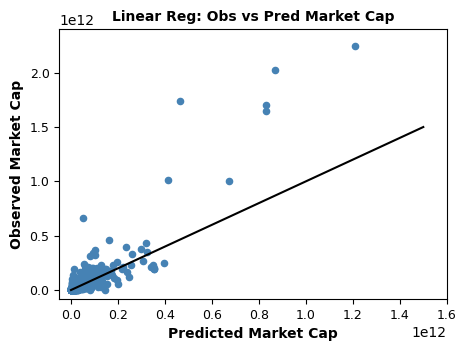

In [221]:
#obs vs pred scatterplot
axes021 = df_lr_model_pred021.plot(x='mc_pred',y='mc_obs',kind='scatter',color='steelblue',figsize=(5,3.5))

axes021.set_title('Linear Reg: Obs vs Pred Market Cap', fontsize = 10.0, fontweight='bold')
axes021.set_xlabel('Predicted Market Cap', fontsize = 10.0, fontweight='bold')
axes021.tick_params(axis='x', labelsize=9)
axes021.set_ylabel('Observed Market Cap', fontsize = 10.0, fontweight='bold') 
axes021.tick_params(axis='y', labelsize=9)
axes021.set_xlim(-0.5*10**11,1.6*10**12)     #set_xlim(-0.1*10**11,0.1*10**12)
axes021.set_ylim(-0.8*10**11,2.4*10**12)     #set_ylim(-0.1*10**11,0.4*10**12)

#y=x line
plt.plot([0,1.5*10**12],[0,1.5*10**12],'-',color='k')

plt.show()

<b>3.2 XGBOOST DECISION TREE </b>

In [279]:
#XGBOOST 
#gridsearch cross validations: hyperparameters
#train data matrix
xgb_DM_train031 = xgb.DMatrix(df_x_train011,label=df_y_train011)
#parameter grid
xgb_gscv_grid031 = {'booster':['gbtree'],'max_depth':[8],'learning_rate':[0.005],'reg_alpha':[0.5]}
#permuations of parameter grid
keys031, values031 = zip(*xgb_gscv_grid031.items())
lst_xgb_gscv_grid031 = [dict(zip(keys031, v031)) for v031 in itool.product(*values031)]

In [280]:
lst_xgb_gscv_grid031[0:19]

[{'booster': 'gbtree',
  'max_depth': 8,
  'learning_rate': 0.005,
  'reg_alpha': 0.5}]

In [281]:
#clock start
gscv_start031 = dttm.datetime.now()
print(gscv_start031)

#parameters
xgb_prmsbase031 = {'booster':'gbtree','max_depth':2,'learning_rate':0.1,'objective':'reg:squarederror',
    'reg_alpha':1,'reg_lambda':0,'min_child_weight':20}
n_trees_try031 = 4000
#results
df_xgb_gscv_res031 = pd.DataFrame()

ct031 = 0
for dictn031 in lst_xgb_gscv_grid031:
    ct031 = ct031 + 1
    
    #update parameters to try
    xgb_prmstry031 = xgb_prmsbase031
    for key031 in dictn031:
        xgb_prmstry031[key031] = dictn031[key031]

    #seed
    seed031 = dttm.datetime.now().microsecond
        
    df_xgb_cv031 = xgb.cv(xgb_prmstry031,xgb_DM_train031,num_boost_round=n_trees_try031,nfold=4,metrics=['mae'],
            early_stopping_rounds=30,as_pandas=True,verbose_eval=False,seed=seed031) 
    n_trees031 = len(df_xgb_cv031.index)
    df_xgb_cvinsrt031 = pd.DataFrame()
    df_xgb_cvinsrt031 = pd.concat( [ pd.DataFrame([ct031,dictn031,n_trees031]).T, df_xgb_cv031.tail(1).reset_index(drop=True) ], axis=1)
    df_xgb_cvinsrt031.columns = ['iteration','param_set','ntrees','infld-mae-mean','infld-mae-std','outfld-mae-mean','outfld-mae-std']
    
    if ct031 == 1:
        df_xgb_gscv_res031 = df_xgb_cvinsrt031.copy()
    else:
        df_xgb_gscv_res031 = pd.concat( [df_xgb_gscv_res031,df_xgb_cvinsrt031.copy()],axis=0,ignore_index=True)
    
    print(xgb_prmstry031)
    print(df_xgb_cv031.tail(1))
    
    
#clock end
gscv_end031 = dttm.datetime.now()
gscv_elapsed031 = gscv_end031 - gscv_start031
print(gscv_start031,gscv_end031,gscv_elapsed031)

2021-11-03 12:38:02.748648
{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.005, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'reg_lambda': 0, 'min_child_weight': 20}
      train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
3999        0.192084       0.012656       0.355338      0.007194
2021-11-03 12:38:02.748648 2021-11-03 13:09:10.693933 0:31:07.945285


In [506]:
#SAVE 
#df_xgb_gscv_res031_20211102
#df_xgb_gscv_res031_20211103 
#df_xgb_gscv_res031_20211104 

pd.set_option('display.max_colwidth',120)
df_xgb_gscv_res031_20211102.sort_values(by='outfld-mae-mean',ascending=True).head(10)

,iteration,param_set,ntrees,infld-mae-mean,infld-mae-std,outfld-mae-mean,outfld-mae-std
15,16,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'reg_alpha': 1.0}",263,0.139986,0.004533,0.352351,0.004793
10,11,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'reg_alpha': 0.5}",586,0.105056,0.001920,0.355253,0.007142
14,15,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'reg_alpha': 0.5}",445,0.087918,0.008108,0.355600,0.012696
11,12,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'reg_alpha': 1.0}",343,0.162071,0.007861,0.358165,0.014807
12,13,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.005, 'reg_alpha': 0.5}",2000,0.257072,0.001285,0.360983,0.007780
6,7,"{'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.1, 'reg_alpha': 0.5}",647,0.194125,0.001709,0.363444,0.003613
13,14,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.005, 'reg_alpha': 1.0}",2000,0.253979,0.004161,0.364972,0.015007
7,8,"{'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.1, 'reg_alpha': 1.0}",622,0.196231,0.001996,0.364978,0.009797
9,10,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.005, 'reg_alpha': 1.0}",2000,0.280371,0.005818,0.367139,0.008116
8,9,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.005, 'reg_alpha': 0.5}",2000,0.285302,0.002721,0.369321,0.009946


In [226]:
#{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'reg_alpha': 1.0}	263	0.352351	0.004793
#{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.005, 'reg_alpha': 0.5}	4000	0.355338	0.007194
xgb_model_best031 = xgb.XGBRegressor(booster='gbtree',n_estimators=263,max_depth=8,learning_rate=0.1,
    objective='reg:squarederror',
    colsample_bynode=1.0,reg_alpha=0.5,reg_lambda=0,tree_method='auto',min_child_weight=20,
    importance_type='total_gain',random_state=dttm.datetime.now().microsecond)

#xgb_model_best031.fit(df_x_train011,df_y_train011,
        #eval_set=[(df_x_train011,df_y_train011),(df_x_test011,df_y_test011)],
        #eval_metric='mae', verbose=False)
xgb_model_best031.fit(df_x_train011,df_y_train011,
        eval_set=[(df_x_train011,df_y_train011)],
        eval_metric='mae', verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1.0, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='total_gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=20, missing=nan, monotone_constraints=None,
             n_estimators=263, n_jobs=0, num_parallel_tree=1,
             random_state=735829, reg_alpha=0.5, reg_lambda=0,
             scale_pos_weight=1, subsample=1, tree_method='auto',
             validate_parameters=False, verbosity=None)

In [315]:
#xgb.plot_tree(xgb_model_best031,num_trees=0)
#plt.show()

In [231]:
#predictions
#transformed
df_xgb_model_pred031 = pd.concat([df_y_test011,pd.Series(xgb_model_best031.predict(df_x_test011),
    index=df_x_test011.index)],axis=1)
df_xgb_model_pred031.columns = ['y_obs','y_pred']

#unscaled, inverse transform
df_xgb_model_pred031 = pd.concat([df_xgb_model_pred031,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_xgb_model_pred031.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_xgb_model_pred_temp031 = pd.concat([df_x_test011.loc[:,['rev']],df_xgb_model_pred031.loc[:,['y_pred']].copy()],axis=1)
df_xgb_model_pred_temp031.columns = ['rev','mktcap_sec_tp1']

lst_xgb_model_pred_invtr031 = inv_transform(df_xgb_model_pred_temp031,df_yx_test_featmap011,k_test011,
    df_yx_test_posneg011,df_yx_test_stats011)
df_xgb_model_pred_invtran031 = lst_xgb_model_pred_invtr031[0]
df_xgb_model_pred_invtran031.columns = ['rev','mc_pred']

df_xgb_model_pred031 = pd.concat([df_xgb_model_pred031,df_xgb_model_pred_invtran031.loc[:,['mc_pred']]],axis=1)

#fit metrics
df_xgb_model_pred031.loc[:,'mc_resid'] = df_xgb_model_pred031.loc[:,'mc_obs'] - df_xgb_model_pred031.loc[:,'mc_pred']
df_xgb_model_pred031.loc[:,'mc_ae'] = df_xgb_model_pred031.loc[:,'mc_resid'].abs()
df_xgb_model_pred031.loc[:,'mc_ape'] = df_xgb_model_pred031.loc[:,'mc_ae']/df_xgb_model_pred031.loc[:,'mc_obs'].abs()
df_xgb_model_pred031 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_xgb_model_pred031],axis=1)

df_xgb_model_pred031.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,11.436157,8.319025,2.245600e+12,1.637078e+12,6.085219e+11,6.085219e+11,0.270984
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,13.407820,11.177863,2.020644e+12,1.599691e+12,4.209538e+11,4.209538e+11,0.208326
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.383738,8.433945,1.644663e+12,1.312003e+12,3.326602e+11,3.326602e+11,0.202266
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.699974,8.433945,1.702156e+12,1.312003e+12,3.901528e+11,3.901528e+11,0.229211
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7.877630,4.861131,1.735721e+12,1.222108e+12,5.136124e+11,5.136124e+11,0.295907
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.810701,7.913795,1.012507e+12,8.896379e+11,1.228692e+11,1.228692e+11,0.121351
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.001895,0.981153,6.632374e+11,1.030587e+11,5.601786e+11,5.601786e+11,0.844613
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,5.790132,4.352474,1.004905e+12,8.125603e+11,1.923443e+11,1.923443e+11,0.191406
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,2.221054,1.311866,1.210672e+11,8.068783e+10,4.037933e+10,4.037933e+10,0.333528
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6.888777,5.710544,4.558462e+11,3.508978e+11,1.049484e+11,1.049484e+11,0.230228


In [275]:
#r-squared, mean-ape, median-ape
xgb_r2 = r2_score(df_xgb_model_pred031.loc[:,'mc_obs'], df_xgb_model_pred031.loc[:,'mc_pred'])
xgb_meanape = df_xgb_model_pred031.loc[:,'mc_ape'].mean()
xgb_medape = df_xgb_model_pred031.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = df_model_testmet_smy011.loc[df_model_testmet_smy011.index<=0,:]
df_model_testmet_smy011 = df_model_testmet_smy011.append(pd.Series(['XGB',xgb_r2,xgb_meanape,xgb_medape],
    index=df_model_testmet_smy011.columns),ignore_index=True)
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.673865,1.758949,0.468692
1,XGB,0.892403,1.592645,0.400851


<b>3.3 SUPPORT VECTOR REGRESSION </b>

In [310]:
#SUPPORT VECTOR REGRESSION
### gridsearch cross validation
#clock start
gscv_start041 = dttm.datetime.now()
print(gscv_start041)

svr_model041 = SVR(kernel='rbf')
  
svr_gscv_grid041 = {'kernel':['rbf'],
    'C':[0.100,0.200,0.340,0.500,0.800],'gamma':[0.010,0.020,0.130,0.200,0.500],
    'epsilon':[0.00005,0.0001,0.0002,0.0005,0.001]}

svr_gscv041 = GridSearchCV( estimator = svr_model041, param_grid = svr_gscv_grid041,
    scoring='neg_mean_absolute_error', cv=4, verbose=2, n_jobs=4 )
svr_gscv041.fit(df_x_train011,df_y_train011.values.ravel())

#clock end
gscv_end041 = dttm.datetime.now()
gscv_elapsed041 = gscv_end041 - gscv_start041
print(gscv_start041,gscv_end041,gscv_elapsed041)

2021-11-03 14:40:15.634006
Fitting 4 folds for each of 125 candidates, totalling 500 fits
2021-11-03 14:40:15.634006 2021-11-03 15:23:06.886059 0:42:51.252053


In [311]:
pd.set_option('display.max_colwidth',80)
df_svr_gscv_res041 = pd.DataFrame(svr_gscv041.cv_results_)
df_svr_gscv_res041.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
57,12.188579,0.363007,7.380338,0.298674,0.34,0.0001,0.13,rbf,"{'C': 0.34, 'epsilon': 0.0001, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264593,-0.362121,-0.226572,-0.272043,-0.531332,0.426149,1
62,12.295262,0.399127,7.497492,0.291286,0.34,0.0002,0.13,rbf,"{'C': 0.34, 'epsilon': 0.0002, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264633,-0.362134,-0.226570,-0.272064,-0.531350,0.426162,2
52,12.233211,0.378066,7.416042,0.293273,0.34,0.00005,0.13,rbf,"{'C': 0.34, 'epsilon': 5e-05, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264632,-0.362139,-0.226578,-0.272062,-0.531353,0.426161,3
67,12.171583,0.335425,7.487791,0.192171,0.34,0.0005,0.13,rbf,"{'C': 0.34, 'epsilon': 0.0005, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264665,-0.362112,-0.226550,-0.272099,-0.531356,0.426177,4
72,12.164306,0.341522,7.460814,0.284637,0.34,0.001,0.13,rbf,"{'C': 0.34, 'epsilon': 0.001, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264742,-0.362113,-0.226543,-0.272094,-0.531373,0.426212,5
97,13.149879,0.446255,7.523622,0.339615,0.5,0.001,0.13,rbf,"{'C': 0.5, 'epsilon': 0.001, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263398,-0.362730,-0.229470,-0.272759,-0.532089,0.424949,6
82,13.358258,0.467337,7.364367,0.363572,0.5,0.0001,0.13,rbf,"{'C': 0.5, 'epsilon': 0.0001, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263391,-0.362765,-0.229423,-0.272825,-0.532101,0.424940,7
92,13.342520,0.519224,7.379963,0.325667,0.5,0.0005,0.13,rbf,"{'C': 0.5, 'epsilon': 0.0005, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263426,-0.362749,-0.229449,-0.272835,-0.532115,0.424951,8
77,13.364445,0.576290,7.482830,0.307683,0.5,0.00005,0.13,rbf,"{'C': 0.5, 'epsilon': 5e-05, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263399,-0.362770,-0.229434,-0.272856,-0.532115,0.424937,9
87,13.385931,0.416557,7.387736,0.295633,0.5,0.0002,0.13,rbf,"{'C': 0.5, 'epsilon': 0.0002, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263433,-0.362771,-0.229426,-0.272854,-0.532121,0.424953,10


In [288]:
#support vector regression - best model

#RBF KERNEL

#{'kernel':['rbf'],'C':[0.100,0.200,0.340,0.500,0.800],'gamma':[0.010,0.020,0.130,0.200,0.500],
    #'epsilon':[0.00005,0.0001,0.0002,0.0005,0.001]}
#C=34, gamma=0.13, epsilon=0.0001; MAE -0.531332

#{'kernel':['rbf'],'C':[0.330,0.340,0.350],'gamma':[0.120,0.130,0.140],'epsilon':[0.00005,0.0001,0.0002]}
#C=0.340, gamma=0.13, epsilon=0.0001; MAE -0.531332
#{'kernel':['rbf'],'C':[0.320,0.330,0.340],'gamma':[0.120,0.130,0.140],'epsilon':[0.0001,0.0002,0.0003]}
#C=0.340, gamma=0.13, epsilon=0.0001; MAE -0.531332
#{'kernel':['rbf'],'C':[0.270,0.290,0.330,0.350,0.370],'gamma':[0.110,0.130,0.150],
    #'epsilon':[0.00002,0.00005,0.0001,0.0002,0.0003]}
#C=0.330, gamma=0.130, epsilon=0.0002; MAE -0.531356
#{'kernel':['rbf'],'C':[0.290,0.310,0.330],'gamma':[0.110,0.130,0.150],
#    'epsilon':[0.0002,0.0003,0.0004,0.0005,0.0006]}
#C=0.330, gamma=0.130, epsilon=0.0002; MAE -0.531356

svr_model_best041 = SVR(kernel='rbf', C=0.340, gamma=0.130, epsilon=0.0001)    
svr_model_best041.fit(df_x_train011,df_y_train011.values.ravel())

SVR(C=0.34, epsilon=0.0001, gamma=0.13)

In [289]:
#predictions
#transformed
df_svr_model_pred041 = pd.concat([df_y_test011,pd.Series(svr_model_best041.predict(df_x_test011),
    index=df_x_test011.index)],axis=1)
df_svr_model_pred041.columns = ['y_obs','y_pred']

#unscaled, inverse transform
df_svr_model_pred041 = pd.concat([df_svr_model_pred041,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_svr_model_pred041.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_svr_model_pred_temp041 = pd.concat([df_x_test011.loc[:,['rev']],df_svr_model_pred041.loc[:,['y_pred']].copy()],axis=1)
df_svr_model_pred_temp041.columns = ['rev','mktcap_sec_tp1']

lst_svr_model_pred_invtr041 = inv_transform(df_svr_model_pred_temp041,df_yx_test_featmap011,k_test011,
    df_yx_test_posneg011,df_yx_test_stats011)
df_svr_model_pred_invtran041 = lst_svr_model_pred_invtr041[0]
df_svr_model_pred_invtran041.columns = ['rev','mc_pred']

df_svr_model_pred041 = pd.concat([df_svr_model_pred041,df_svr_model_pred_invtran041.loc[:,['mc_pred']]],axis=1)

#fit metrics
df_svr_model_pred041.loc[:,'mc_resid'] = df_svr_model_pred041.loc[:,'mc_obs'] - df_svr_model_pred041.loc[:,'mc_pred']
df_svr_model_pred041.loc[:,'mc_ae'] = df_svr_model_pred041.loc[:,'mc_resid'].abs()
df_svr_model_pred041.loc[:,'mc_ape'] = df_svr_model_pred041.loc[:,'mc_ae']/df_svr_model_pred041.loc[:,'mc_obs'].abs()
df_svr_model_pred041 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_svr_model_pred041],axis=1)

df_svr_model_pred041.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,11.436157,-0.090749,2.245600e+12,4.740407e+11,1.771559e+12,1.771559e+12,0.788902
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,13.407820,0.128907,2.020644e+12,2.384850e+11,1.782159e+12,1.782159e+12,0.881976
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.383738,-0.071026,1.644663e+12,3.000413e+11,1.344622e+12,1.344622e+12,0.817567
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.699974,-0.071026,1.702156e+12,3.000413e+11,1.402115e+12,1.402115e+12,0.823729
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7.877630,-0.091845,1.735721e+12,5.737022e+11,1.162018e+12,1.162018e+12,0.669473
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.810701,0.104088,1.012507e+12,1.555492e+11,8.569578e+11,8.569578e+11,0.846372
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.001895,-0.552204,6.632374e+11,4.548605e+10,6.177513e+11,6.177513e+11,0.931418
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,5.790132,-0.095049,1.004905e+12,3.467820e+11,6.581226e+11,6.581226e+11,0.654911
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,2.221054,0.701151,1.210672e+11,5.814823e+10,6.291893e+10,6.291893e+10,0.519703
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6.888777,0.541190,4.558462e+11,5.248774e+10,4.033584e+11,4.033584e+11,0.884856


In [290]:
#r-squared, mean-ape, median-ape
svr_r2 = r2_score(df_svr_model_pred041.loc[:,'mc_obs'], df_svr_model_pred041.loc[:,'mc_pred'])
svr_meanape = df_svr_model_pred041.loc[:,'mc_ape'].mean()
svr_medape = df_svr_model_pred041.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = df_model_testmet_smy011.loc[df_model_testmet_smy011.index<=1,:]
df_model_testmet_smy011 = df_model_testmet_smy011.append(pd.Series(['SVR',svr_r2,svr_meanape,svr_medape],
    index=df_model_testmet_smy011.columns),ignore_index=True)
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.673865,1.758949,0.468692
1,XGB,0.892403,1.592645,0.400851
2,SVR,0.359517,1.504365,0.427169


## 4 Neural Network Model

ABC

In [484]:
#NEURAL NETWORK MODEL
#dataframe to tensor
tsr_x_train011 = tf.convert_to_tensor(df_x_train011)

#try for k-best linear model 
#df_x_kbest_train021 = df_x_train011.loc[:,lr_feat_kbest021]
#tsr_x_train011 = tf.convert_to_tensor(df_x_train011.loc[:,lr_feat_kbest021])

tsr_y_train011 = tf.convert_to_tensor(df_y_train011)

tsr_x_test011 = tf.convert_to_tensor(df_x_test011)
tsr_y_test011 = tf.convert_to_tensor(df_y_test011)

In [485]:
tsr_x_train011.shape[1]

23

In [486]:
#NN linear model
#inputs
nn_input051 = keras.Input(shape=tsr_x_train011.shape[1])
#layer 1
lay_lin01 = layers.Dense(1, activation='linear')(nn_input051)
#output
nn_output051 = layers.Dense(1, activation='linear', use_bias=False, kernel_initializer='Ones', 
    trainable=False)(lay_lin01)

#model
nn_model051 = keras.Model(inputs=nn_input051, outputs=nn_output051, name='nn_model051')
nn_model051.summary()

Model: "nn_model051"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 23)]              0         
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 24        
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 1         
Total params: 25
Trainable params: 24
Non-trainable params: 1
_________________________________________________________________


In [490]:
#NN Linear + NonLinear 2-Layer Model
#inputs
nn_input051 = keras.Input(shape=tsr_x_train011.shape[1])
#layer 1
lay_nonlin01 = layers.Dense(10, activation='relu', 
    kernel_regularizer=keras.regularizers.L1(l1=0.1), bias_regularizer=keras.regularizers.L1(l1=0.1))(nn_input051)
#layer 2
lay_lin02 = layers.Dense(1, activation='linear',
    kernel_regularizer=keras.regularizers.L1(l1=0.1), bias_regularizer=keras.regularizers.L1(l1=0.1))(nn_input051)
lay_nonlin02 = layers.Dense(10, activation='relu',
    kernel_regularizer=keras.regularizers.L1(l1=0.1), bias_regularizer=keras.regularizers.L1(l1=0.1))(lay_nonlin01)
lay_02 = layers.concatenate([lay_lin02,lay_nonlin02])
#output
nn_output051 = layers.Dense(1, activation='linear', use_bias=False, kernel_initializer='Ones', 
    trainable=False)(lay_02)

#model
nn_model052 = keras.Model(inputs=nn_input051, outputs=nn_output051, name='nn_model052')
nn_model052.summary()


Model: "nn_model052"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 23)]         0                                            
__________________________________________________________________________________________________
dense_117 (Dense)               (None, 10)           240         input_41[0][0]                   
__________________________________________________________________________________________________
dense_118 (Dense)               (None, 1)            24          input_41[0][0]                   
__________________________________________________________________________________________________
dense_119 (Dense)               (None, 10)           110         dense_117[0][0]                  
________________________________________________________________________________________

In [659]:
#NN Linear + NonLinear 3-Layer Model
#inputs
nn_input051 = keras.Input(shape=tsr_x_train011.shape[1])
#layer 1
lay_nonlin01 = layers.Dense(10, activation='relu')(nn_input051)
#layer 2
lay_nonlin02 = layers.Dense(10, activation='relu')(lay_nonlin01)
#layer 3
lay_lin03 = layers.Dense(1, activation='linear')(nn_input051)
lay_nonlin03 = layers.Dense(10, activation='relu')(lay_nonlin02)
lay_03 = layers.concatenate([lay_lin03,lay_nonlin03])
#output
nn_output051 = layers.Dense(1, activation='linear')(lay_03)

#model
nn_model053 = keras.Model(inputs=nn_input051, outputs=nn_output051, name='nn_model052')
nn_model053.summary()

Model: "nn_model052"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, 23)]         0                                            
__________________________________________________________________________________________________
dense_207 (Dense)               (None, 10)           240         input_63[0][0]                   
__________________________________________________________________________________________________
dense_208 (Dense)               (None, 10)           110         dense_207[0][0]                  
__________________________________________________________________________________________________
dense_209 (Dense)               (None, 1)            24          input_63[0][0]                   
________________________________________________________________________________________

In [663]:
#TRY
#NN Linear + NonLinear 2-Layer Model
#inputs
nn_input051 = keras.Input(shape=tsr_x_train011.shape[1])
#layer 1
lay_nonlin01 = layers.Dense(10, activation='relu', 
    kernel_initializer=keras.initializers.RandomUniform(minval=-0.1, maxval=0.1, seed=dttm.datetime.now().microsecond), 
    bias_initializer='zeros',
    kernel_regularizer=keras.regularizers.L1(l1=0.1), bias_regularizer=keras.regularizers.L1(l1=0.1))(nn_input051)
#layer 2
lay_lin02 = layers.Dense(1, activation='linear',
    kernel_initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=dttm.datetime.now().microsecond), 
    bias_initializer='zeros',
    kernel_regularizer=keras.regularizers.L1(l1=0.05), bias_regularizer=keras.regularizers.L1(l1=0.05))(nn_input051)
lay_nonlin02 = layers.Dense(10, activation='relu',
    kernel_initializer=keras.initializers.RandomUniform(minval=-0.1, maxval=0.1, seed=dttm.datetime.now().microsecond), 
    bias_initializer='zeros',
    kernel_regularizer=keras.regularizers.L1(l1=0.1), bias_regularizer=keras.regularizers.L1(l1=0.1))(lay_nonlin01)
lay_02 = layers.concatenate([lay_lin02,lay_nonlin02])
#output
nn_output051 = layers.Dense(1, activation='linear', use_bias=False, kernel_initializer='Ones', 
    trainable=False)(lay_02)

#model
nn_model052 = keras.Model(inputs=nn_input051, outputs=nn_output051, name='nn_model052')
nn_model052.summary()

Model: "nn_model052"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 23)]         0                                            
__________________________________________________________________________________________________
dense_216 (Dense)               (None, 10)           240         input_65[0][0]                   
__________________________________________________________________________________________________
dense_217 (Dense)               (None, 1)            24          input_65[0][0]                   
__________________________________________________________________________________________________
dense_218 (Dense)               (None, 10)           110         dense_216[0][0]                  
________________________________________________________________________________________

In [664]:
#callback
#nn_chkpt_flpth051 = 'nn_model_lin01'
#nn_chkpt_flpth051 = 'nn_model_nlin02_adm'
nn_chkpt_flpth051 = 'nn_model_nlin02_sgd'
nn_chkpt_chkpt051 = keras.callbacks.ModelCheckpoint(filepath=nn_chkpt_flpth051, save_weights_only=False, 
    monitor='val_mean_absolute_error', mode='min', save_best_only=True)

#reload last best model
#nn_model052 = keras.models.load_model('nn_model_nlin02_sgd001')

#keras.optimizers.Adam()
#keras.optimizers.SGD()
nn_model052.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), 
    loss=keras.losses.MeanAbsoluteError(), 
    metrics=keras.metrics.MeanAbsoluteError())

nn_model_hist052 = nn_model052.fit(x=tsr_x_train011,y=tsr_y_train011, epochs=30, verbose=1, validation_split=0.25, 
    callbacks=[nn_chkpt_chkpt051])

#test_scores = model.evaluate(x_test, y_test, verbose=2)

Epoch 1/30
182/182 [==============================] - 6s 24ms/step - loss: 2.3708 - mean_absolute_error: 1.2288 - val_loss: 0.9599 - val_mean_absolute_error: 0.7030
INFO:tensorflow:Assets written to: nn_model_nlin02_sgd/assets
Epoch 2/30
182/182 [==============================] - 1s 6ms/step - loss: 0.8957 - mean_absolute_error: 0.6737 - val_loss: 0.4932 - val_mean_absolute_error: 0.3588
INFO:tensorflow:Assets written to: nn_model_nlin02_sgd/assets
Epoch 3/30
182/182 [==============================] - 1s 7ms/step - loss: 0.6550 - mean_absolute_error: 0.5375 - val_loss: 0.4275 - val_mean_absolute_error: 0.3323
INFO:tensorflow:Assets written to: nn_model_nlin02_sgd/assets
Epoch 4/30
182/182 [==============================] - 1s 6ms/step - loss: 0.6132 - mean_absolute_error: 0.5217 - val_loss: 0.3925 - val_mean_absolute_error: 0.3139
INFO:tensorflow:Assets written to: nn_model_nlin02_sgd/assets
Epoch 5/30
182/182 [==============================] - 1s 6ms/step - loss: 0.6153 - mean_absolut

In [667]:
#nn_model051 = keras.models.load_model('nn_model_lin01')
nn_model052 = keras.models.load_model('nn_model_nlin02_sgd_mae2838')

#nn_model_hist051_adam01, nn_model_hist051_sgd01
#nn_model_hist051_sgd01 = nn_model052
#nn_model051.layers[2].get_weights()[1]
#nn_model052.layers[1].get_weights()[0]
#nn_model052.layers[2].get_weights()[0]
#nn_model052.layers[3].get_weights()[0]

pd.concat([pd.DataFrame(df_x_train011.columns,columns=['feat']),
    pd.DataFrame(nn_model052.layers[2].get_weights()[0],columns=['weight'])],axis=1).sort_values(by='weight')

#pd.DataFrame(nn_model_hist052.history).sort_values(by='val_mean_absolute_error').head(10)

,feat,weight
4,gp_mgn_flg,-0.176542
7,gp_mgn_ydy,-0.099904
22,cf_op_mgn_ydy,-0.010551
1,rev,-0.004390
16,div_flg,-0.003433
12,sh_iss_flg,-0.001919
11,ni_mgn_ydy,-0.001763
3,rev_yoy_qdq,-0.001453
10,ni_mgn,-0.000865
14,sh_rprch_flg,-0.000645


In [668]:
#predictions
#transformed
#tsr_x_test011 = tf.convert_to_tensor(df_x_test011.loc[:,lr_feat_kbest021])

df_nn_model_pred051 = pd.concat([df_y_test011,pd.Series(nn_model052.predict(tsr_x_test011).ravel(),
    index=df_x_test011.index)],axis=1)
df_nn_model_pred051.columns = ['y_obs','y_pred']

#unscaled, inverse transform
df_nn_model_pred051 = pd.concat([df_nn_model_pred051,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_nn_model_pred051.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_nn_model_pred_temp051 = pd.concat([df_x_test011.loc[:,['rev']],df_nn_model_pred051.loc[:,['y_pred']].copy()],axis=1)
df_nn_model_pred_temp051.columns = ['rev','mktcap_sec_tp1']

lst_nn_model_pred_invtr051 = inv_transform(df_nn_model_pred_temp051,df_yx_test_featmap011,k_test011,
    df_yx_test_posneg011,df_yx_test_stats011)
df_nn_model_pred_invtr051 = lst_nn_model_pred_invtr051[0]
df_nn_model_pred_invtr051.columns = ['rev','mc_pred']

df_nn_model_pred051 = pd.concat([df_nn_model_pred051,df_nn_model_pred_invtr051.loc[:,['mc_pred']]],axis=1)

#fit metrics
df_nn_model_pred051.loc[:,'mc_resid'] = df_nn_model_pred051.loc[:,'mc_obs'] - df_nn_model_pred051.loc[:,'mc_pred']
df_nn_model_pred051.loc[:,'mc_ae'] = df_nn_model_pred051.loc[:,'mc_resid'].abs()
df_nn_model_pred051.loc[:,'mc_ape'] = df_nn_model_pred051.loc[:,'mc_ae']/df_nn_model_pred051.loc[:,'mc_obs'].abs()
df_nn_model_pred051 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_nn_model_pred051],axis=1)

df_nn_model_pred051.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,11.436157,0.749321,2.245600e+12,5.588162e+11,1.686783e+12,1.686783e+12,0.751151
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,13.407820,1.887729,2.020644e+12,3.744782e+11,1.646166e+12,1.646166e+12,0.814674
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.383738,1.013896,1.644663e+12,3.893768e+11,1.255287e+12,1.255287e+12,0.763248
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.699974,1.013896,1.702156e+12,3.893768e+11,1.312779e+12,1.312779e+12,0.771245
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7.877630,-0.601364,1.735721e+12,5.207442e+11,1.214976e+12,1.214976e+12,0.699984
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.810701,0.926741,1.012507e+12,2.044914e+11,8.080157e+11,8.080157e+11,0.798035
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.001895,-0.240523,6.632374e+11,5.530832e+10,6.079290e+11,6.079290e+11,0.916609
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,5.790132,0.563903,1.004905e+12,4.034642e+11,6.014404e+11,6.014404e+11,0.598505
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,2.221054,0.177441,1.210672e+11,4.175360e+10,7.931355e+10,7.931355e+10,0.655120
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6.888777,0.810923,4.558462e+11,6.153223e+10,3.943139e+11,3.943139e+11,0.865015


In [669]:
#r-squared, mean-ape, median-ape
nn_r2 = r2_score(df_nn_model_pred051.loc[:,'mc_obs'], df_nn_model_pred051.loc[:,'mc_pred'])
nn_meanape = df_nn_model_pred051.loc[:,'mc_ape'].mean()
nn_medape = df_nn_model_pred051.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = df_model_testmet_smy011.loc[df_model_testmet_smy011.index<=2,:]
df_model_testmet_smy011 = df_model_testmet_smy011.append(pd.Series(['NN',nn_r2,nn_meanape,nn_medape],
    index=df_model_testmet_smy011.columns),ignore_index=True)
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.673865,1.758949,0.468692
1,XGB,0.892403,1.592645,0.400851
2,SVR,0.359517,1.504365,0.427169
3,NN,0.416428,1.732574,0.518684


In [ ]:
####### MODELING NOTES ########

#CHECK LINEAR NN
#['gp' 'gp_mgn' 'ni' 'ni_mgn' 'sh_rprch' 'div' 'cf_op' 'cf_op_mgn']
#[ 0.10183303  0.09756931  0.17023976 -0.0463247   0.42449517  0.38671133 0.14474486 -0.01331413]

#tf.keras.layers.Layer.weights
#kernel weights
#nn_model051.layers[1].kernel
#nn_model051.layers[1].get_weights()[0]
#bias
#nn_model051.layers[1].get_weights()[1]

#pd.concat([pd.DataFrame(df_x_train011.columns,columns=['feat']),
#    pd.DataFrame(nn_model052.layers[2].get_weights()[0],columns=['weight'])],axis=1).sort_values(by='weight')


df_xplot011 = df_yx_train_tran2011.loc[:,'rev_yoy']
df_yplot011 = df_yx_train_tran2011.loc[:,'mktcap_sec_tp1']
ax901 = sns.regplot(x=df_xplot011,y=df_yplot011,color='steelblue')
ax901.set_xlim(-2,6) 
plt.show()





#TEST TRANSFORM  
featn901 = 'mktcap_sec_tp1'
stats901 = df_yx_test_stats011.loc[df_yx_test_stats011.loc[:,'feat']==featn901,:]
b0_901 = stats901.iloc[0][1]
b1_901 = stats901.iloc[0][2]
mn1_901 = stats901.iloc[0][5]
std1_901 = stats901.iloc[0][6]
#print(stats901)
tr900 = df_yx_test_core011.loc[0:11,featn901]
revtr900 = df_yx_test_core011.loc[0:11,'rev']

tr901 = tr900**(1/2)
revtr901 = revtr900**(1/2)

tr902r = tr901 - (b0_901 + b1_901*revtr901)
tr902 = (tr902r - mn1_901)/std1_901 

itr901r = std1_901*tr902 + mn1_901
itr901 = itr901r + (b0_901 + b1_901*revtr901)

#print(tr900)
print(tr901)
#print(tr902r)
print(tr902)
print(itr901r)
print(itr901)

#featn901 = 'div_flg'
#featn901 = 'clsadj_etf_t'
#featn901 = 'rev'
#featn901 = 'mktcap_sec_tp1'
featn901 = 'gp'

print(df_yx_test_core011.loc[0:11,featn901])

print(df_yx_test_tran1011.loc[0:11,featn901])
print(df_yx_test_tran2011.loc[0:11,featn901])

print(df_yx_test_invtran1011.loc[0:11,featn901])
print(df_yx_test_invtran2011.loc[0:11,featn901])
